In [ ]:
from xgboost import XGBClassifier

from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.model_selection import KFold

from tensorflow.keras import models

import pandas as pd
import numpy as np
import os, itertools
import matplotlib.pyplot as plt

pixel = 224
PATH = os.path.join(f'./drive/MyDrive/Skin Cancer MNIST: HAM10000/data/input')
n_classes = 7

In [ ]:
def plot_confusion_matrix(cm, target_names=None, cmap=None, normalize=True, labels=True, title='Confusion matrix'):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names)
        plt.yticks(tick_marks, target_names)
    
    if labels:
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            if normalize:
                plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                         horizontalalignment="center",
                         color="white" if cm[i, j] > thresh else "black")
            else:
                plt.text(j, i, "{:,}".format(cm[i, j]),
                         horizontalalignment="center",
                         color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

### Load feature extractor & dataset

In [ ]:
feature_extractor = models.load_model(os.path.join(PATH, "../VGG16_feature_extractor_8K.h5"))

In [ ]:
X_train_img = np.load(os.path.join(PATH, f"X_train_img_{pixel}_seed24.npy"))

y_train = np.load(os.path.join(PATH, "y_train_seed24.npy"))

X_train_meta = pd.read_csv(os.path.join(PATH, "X_train_meta_seed24.csv"))

In [ ]:
X_test_img = np.load(os.path.join(PATH, f"X_test_img_{pixel}_seed24.npy"))

y_test = np.load(os.path.join(PATH, "y_test_seed24.npy"))

X_test_meta = pd.read_csv(os.path.join(PATH, "X_test_meta_seed24.csv"))

In [ ]:
train_features = feature_extractor.predict(X_train_img)

In [ ]:
X_train_df = pd.concat((X_train_meta, pd.DataFrame(train_features)), axis=1)
X_train_df.head()

,female,male,abdomen,acral,back,chest,ear,face,foot,genital,hand,lower extremity,neck,scalp,trunk,unknown,upper extremity,confocal,consensus,follow_up,histo,age,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,...,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63
0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,-1.587673,0.0,0.088662,0.410503,0.926919,0.000000,0.837986,0.367973,0.903606,0.037127,0.491733,0.543486,1.423382,0.767977,0.0000,0.194759,0.000000,0.000000,0.446541,...,0.000000,0.000000,0.000000,0.0,0.899462,0.355264,0.944800,0.000000,0.0,0.000000,0.267575,0.000000,0.000000,0.000000,0.000000,0.238134,0.0,0.000000,0.000000,0.917665,0.330917,0.00000,0.911525,0.000000,0.000000,1.056381,0.0,0.0,0.000000,0.715753,1.259333,0.000000,0.000000,1.295074,0.0,0.00000,1.005004,0.000000,1.205321,0.000000
1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,-0.405658,0.0,0.000000,0.000000,0.810397,0.000000,0.555950,0.909054,1.165976,0.000000,0.000000,1.340066,0.936658,1.045890,0.7491,0.000000,0.198687,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,1.117434,0.331546,0.989922,0.000000,0.0,0.000000,0.636182,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,1.015174,1.313121,0.00000,1.172597,0.000000,0.000000,0.902882,0.0,0.0,0.000000,0.709487,0.818800,0.000000,0.000000,1.102030,0.0,0.00000,0.981082,0.000000,1.051811,0.000000
2,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1.071862,0.0,0.460158,0.287038,0.438903,0.592161,0.025475,1.287891,0.178018,0.000000,0.000000,0.445873,0.514410,1.710272,0.0000,0.000000,0.000000,0.429299,0.000000,...,0.192517,0.272460,0.397119,0.0,0.705847,0.000000,0.000000,0.000000,0.0,0.440951,0.739725,0.065570,0.000000,0.054354,0.000000,0.000000,0.0,0.819820,0.000000,0.494005,0.414339,0.18645,0.219411,0.108016,0.000000,0.092782,0.0,0.0,1.123961,0.514851,0.000000,0.249635,1.239331,0.725601,0.0,0.00000,0.256914,0.234791,0.167679,0.000000
3,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1.071862,0.0,0.000000,0.849092,0.000000,0.000000,0.000000,1.378346,0.000000,0.314483,1.366482,1.496527,0.403947,0.142069,0.0000,1.842239,0.000000,0.000000,1.406876,...,0.000000,0.225079,0.000000,0.0,1.256273,0.561838,0.225129,0.000000,0.0,0.000000,0.000000,0.000000,1.458229,0.000000,0.000000,1.939692,0.0,0.130644,0.000000,0.000000,0.352226,0.00000,1.055159,0.000000,0.000000,0.000000,0.0,0.0,0.352756,1.089761,0.000000,0.000000,0.000000,0.693408,0.0,0.00000,1.037156,0.000000,0.607454,0.000000
4,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1.958373,0.0,0.561376,0.167016,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,1.363674,0.000000,...,0.857500,0.000000,0.000000,0.0,0.000000,0.522682,0.000000,1.123624,0.0,1.277761,0.494984,1.087734,1.308807,0.000000,2.154109,0.046519,0.0,1.935926,2.112564,0.000000,0.000000,0.00000,0.000000,1.155866,1.957821,0.000000,0.0,0.0,0.775381,0.000000,0.000000,0.785495,0.392224,0.000000,0.0,0.12823,0.000000,0.000000,0.000000,1.477142


### model training

In [ ]:
clf = XGBClassifier(
    objective='multi:softmax',
    random_state=0
)

In [ ]:
clf.fit(
    X_train_df, np.argmax(y_train, axis=1),
    verbose=True      
)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
y_pred_train = clf.predict(X_train_df)
y_true_train = np.argmax(y_train, axis=1)

print(classification_report(y_true_train, y_pred_train))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       272
           1       0.97      0.95      0.96       412
           2       0.96      0.96      0.96       883
           3       0.98      0.96      0.97        93
           4       0.98      0.99      0.99      5347
           5       1.00      0.97      0.99       112
           6       0.96      0.92      0.94       893

    accuracy                           0.98      8012
   macro avg       0.98      0.96      0.97      8012
weighted avg       0.98      0.98      0.98      8012



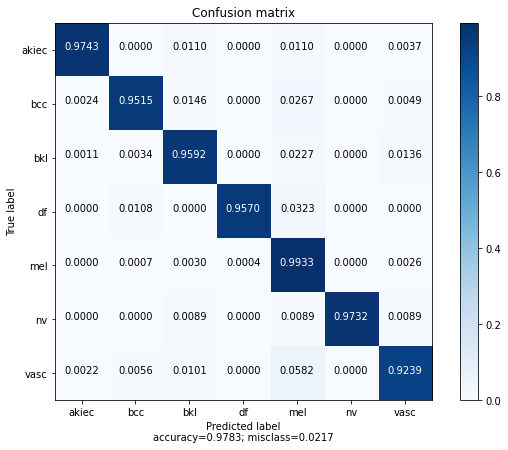

In [ ]:
classes = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
plot_confusion_matrix(confusion_matrix(y_true_train, y_pred_train), target_names=classes)

### model test

In [ ]:
test_features = feature_extractor.predict(X_test_img)

X_test_df = pd.concat([X_test_meta, pd.DataFrame(test_features)], axis=1)
X_test_df.head()

,female,male,abdomen,acral,back,chest,ear,face,foot,genital,hand,lower extremity,neck,scalp,trunk,unknown,upper extremity,confocal,consensus,follow_up,histo,age,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,...,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63
0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1.071862,2.047864,0.073218,0.000000,0.000000,1.304874,0.000000,0.000000,0.000000,0.961145,0.000000,0.000000,0.000000,0.000000,0.804638,0.000000,0.720493,1.669359,0.000000,...,1.929328,0.000000,1.214759,1.610472,0.000000,0.019427,0.000000,2.091880,2.192142,2.18886,0.000000,1.777593,0.000000,0.751301,1.689977,0.000000,1.020278,0.067361,2.218687,0.000000,0.000000,1.281314,0.000000,2.376461,2.481925,0.000000,1.375065,1.786678,0.000377,0.000000,0.000000,2.194973,0.468213,0.000000,1.488407,2.150526,0.000000,0.785911,0.000000,1.627921
1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,-1.587673,0.000000,0.282658,0.000000,1.153053,0.000000,0.916009,0.000000,1.055148,0.051039,1.049236,0.000000,0.734431,0.000000,0.201020,0.747973,0.000000,0.000000,1.165794,...,0.000000,0.204442,0.000000,0.000000,0.148488,0.704886,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,1.032493,0.047379,0.000000,0.960210,0.000000,0.000000,0.000000,1.169120,0.054292,0.000000,0.000000,0.000000,0.000000,1.121249,0.000000,0.000000,0.000000,0.574077,0.985947,0.000000,0.000000,0.431312,0.000000,0.000000,0.724594,0.158561,1.070756,0.000000
2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,-2.178681,0.000000,0.544979,1.343824,0.027884,0.000000,1.081588,0.744950,0.194529,0.239494,1.314127,0.937702,0.884230,0.118061,0.000000,0.459468,0.000000,0.000000,0.915742,...,0.000000,0.022033,0.000000,0.000000,0.922337,0.830735,0.773517,0.000000,0.000000,0.00000,0.000000,0.000000,0.937486,0.000000,0.000000,1.133127,0.000000,0.000000,0.000000,0.000000,0.417225,0.000000,1.378258,0.000000,0.000000,0.331143,0.000000,0.047805,0.142680,0.760993,0.303423,0.000000,0.000000,1.431372,0.000000,0.000000,1.701986,0.073105,0.865144,0.000000
3,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.185350,0.000000,0.000000,0.000000,0.788503,0.000000,0.222473,0.842101,1.078759,0.000000,0.000000,1.113648,1.040972,1.240843,0.629937,0.000000,0.068777,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.032038,0.337343,0.741430,0.000000,0.000000,0.00000,0.447686,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.992451,1.248366,0.010264,0.967389,0.000000,0.000000,0.784715,0.000000,0.000000,0.019307,0.929098,0.841402,0.000000,0.000000,1.179301,0.000000,0.000000,0.924471,0.000000,1.052249,0.000000
4,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,-0.110154,0.203928,0.000000,2.570927,0.000000,2.827471,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.269272,0.000000,...,3.072149,2.796370,3.373709,2.175082,1.723824,0.000000,0.000000,1.695391,0.545702,0.38291,4.165056,0.000000,0.000000,0.000000,2.077275,0.000000,0.000000,0.418192,1.988633,0.000000,0.000000,3.465114,0.000000,1.856012,0.000000,0.000000,1.133460,1.714941,0.189209,0.000000,0.000000,3.260577,1.858744,0.000000,2.536845,0.000000,0.000000,0.845518,0.000000,0.000000


In [ ]:
y_pred_test = clf.predict(X_test_df)
y_true_test = np.argmax(y_test, axis=1)

print(classification_report(y_true_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.85      0.96      0.91        55
           1       0.94      0.90      0.92       102
           2       0.91      0.90      0.91       216
           3       1.00      0.86      0.93        22
           4       0.97      0.98      0.98      1358
           5       1.00      0.90      0.95        30
           6       0.92      0.88      0.90       220

    accuracy                           0.96      2003
   macro avg       0.94      0.91      0.93      2003
weighted avg       0.96      0.96      0.96      2003



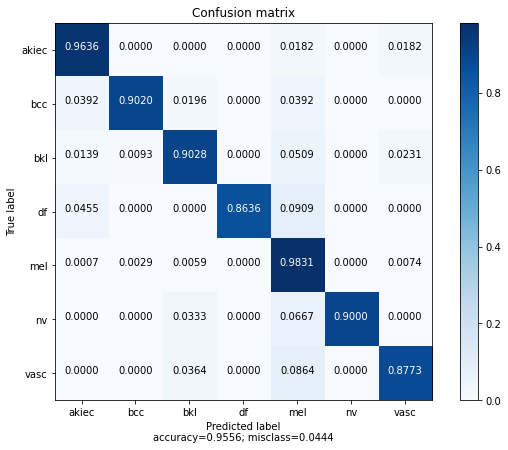

In [ ]:
plot_confusion_matrix(confusion_matrix(y_true_test, y_pred_test), target_names=classes)

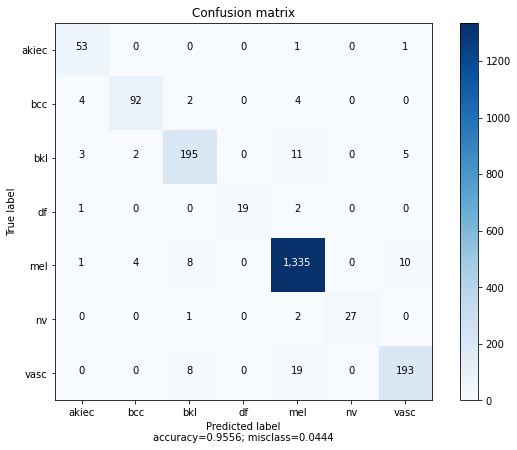

In [ ]:
plot_confusion_matrix(confusion_matrix(y_true_test, y_pred_test), target_names=classes, normalize=False)

### Validation test

In [ ]:
def exec_kfold(clf,folds=5):
    #폴드 세트를 5개인 KFold객체를 생성, 폴드 수만큼 예측결과 저장을 위한 리스트 객체 생성.
    kfold=KFold(n_splits=folds)
    scores=[]
    
    #KFold 교차 검증 수행.
    for iter_count, (train_index, test_index) in enumerate(kfold.split(X_train_df)):
      
        # X_train_df 데이터에서 교차 검증별로 학습과 검증데이터를 가리키는 index 생성
        X_train_tmp, X_test_tmp = X_train_df.values[train_index], X_train_df.values[test_index]
        y_train_tmp = pd.DataFrame(np.argmax(y_train, axis=1)).values[train_index]
        y_test_tmp = pd.DataFrame(np.argmax(y_train, axis=1)).values[test_index]

        #Classifier 학습, 예측, f1-score 계산
        clf.fit(X_train_tmp, y_train_tmp)
        predictions = clf.predict(X_test_tmp)
        f1 = f1_score(y_test_tmp, predictions, average='macro')
        scores.append(f1)
        print(f"F1-Score, iter count {iter_count+1}: {f1:.4f}")
        
        # 5개 fold에서의 평균 f1-score 계산.
        mean_score = np.mean(scores)
        print(f"F1-Score, average: {mean_score:.4f}")
        
exec_kfold(clf, folds=5)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


F1-Score, iter count 1: 0.9389
F1-Score, average: 0.9389
F1-Score, iter count 2: 0.9230
F1-Score, average: 0.9309
F1-Score, iter count 3: 0.9180
F1-Score, average: 0.9266
F1-Score, iter count 4: 0.9026
F1-Score, average: 0.9206
F1-Score, iter count 5: 0.9212
F1-Score, average: 0.9208
